<a href="https://colab.research.google.com/github/Lucs1590/vgg_bpca/blob/master/notebooks/vgg_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG NET
Here we are using a VGG net with 19 layers with the dataset cifar 100.

We are trying to reproduce the results of the paper [1] and after we will try to change some layers and see how it affects the results.

[1] https://arxiv.org/pdf/1409.1556.pdf


# Imports

In [ ]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.applications.vgg16 import decode_predictions, preprocess_input
from keras.preprocessing import image
from PIL import Image

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import backend
from keras.applications import imagenet_utils
from keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,
                             TensorBoard)
from keras.datasets import cifar100
from keras.engine import training
from keras.layers import (Conv2D, Dense, Flatten, GlobalAveragePooling2D,
                          GlobalMaxPooling2D, Input, MaxPooling2D,
                          VersionAwareLayers)
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras.utils import data_utils, layer_utils, to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  img_to_array, load_img)

# Load the dataset

In [8]:
np.random.seed(77)
tf.random.set_seed(77)

In [9]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

We will split the test set in two parts, where one of this will be used to validation. After that we will declare the classes and plot some random images.

In [10]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.7)

In [11]:
labels =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
           'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
           'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

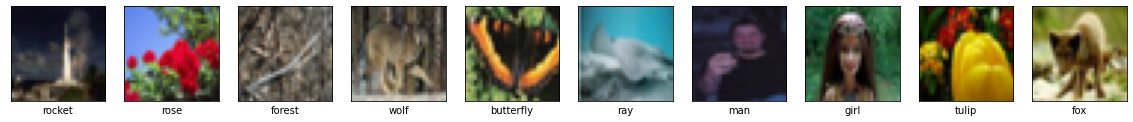

In [12]:
plt.figure(figsize=(20, 3))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    numb = random.randint(0,len(X_train))

    plt.imshow(X_train[numb], cmap="gray")
    plt.xlabel(labels[y_train[numb].astype(int)[0]])
    
plt.show()

Here the data will be converted to a scale between 0 and 1.

In [13]:
print(f'Train: {len(X_train)}')
print(f'Test: {len(X_test)}')
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
y_valid = to_categorical(y_valid, 100)

Train: 50000
Test: 3000


The last thing in this step is apply a lot of filters to the train dataset.

In [14]:
datagen = ImageDataGenerator(
    height_shift_range=0.25,
    width_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

datagen.fit(X_train)

## Auxiliary Code

In [ ]:
def _load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


def _get_predictions(model, images):
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(80, 40)
    for idx in range(4):
        ax[idx].imshow(
            Image.open(images[idx]).resize((200, 200), Image.ANTIALIAS)
        )
    plt.show()

    fig, axes = plt.subplots(1, 4)
    fig.set_size_inches(80, 20)
    for idx, img_path in enumerate(images):
        img = _load_image(img_path)
        preds = decode_predictions(model.predict(img), top=3)[0]
        bars = sns.barplot(
            y=[c[1] for c in preds],
            x=[c[2] for c in preds],
            color="gray",
            ax=axes[idx]
        )
        bars.tick_params(labelsize=55)
        fig.tight_layout()

# VGG Archtecture

## VGG 16
- The cons of this architecture are that it is slow to train and produces the model with very large size.
- A total of 13 convolutional layers are stacked one after the other and 3 dense layers for classification.


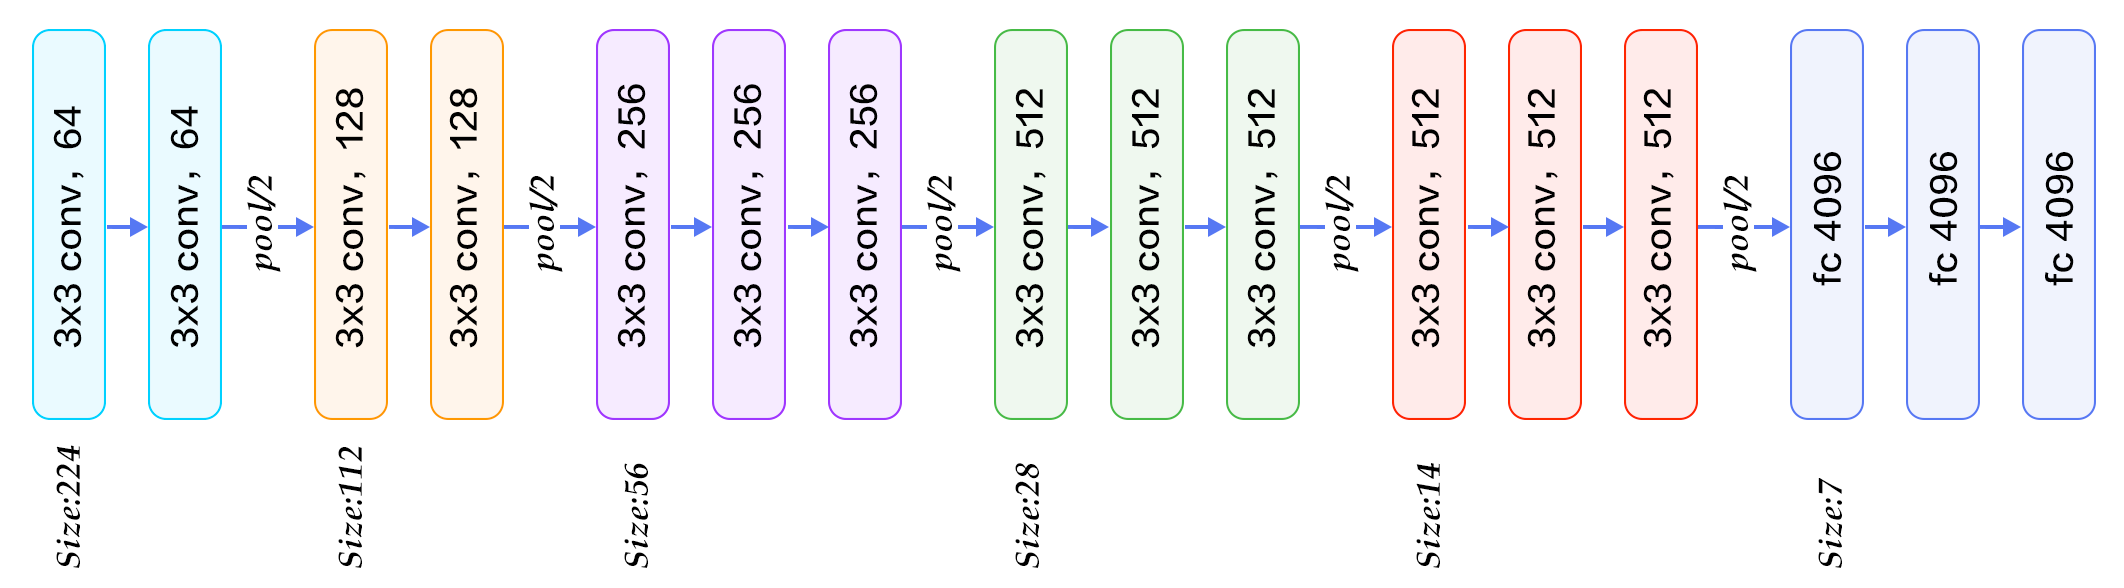

In [31]:
layers = VersionAwareLayers()
WEIGHTS_PATH = (
    "https://storage.googleapis.com/tensorflow/keras-applications/"
    "vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5"
)
WEIGHTS_PATH_NO_TOP = (
    "https://storage.googleapis.com/tensorflow/"
    "keras-applications/vgg16/"
    "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
)

def VGG16(include_top=True, weights='imagenet', input_shape=None, pooling=None, classes=1000, classifier_activation='softmax'):
    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=224,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights
    )

    img_input = layers.Input(shape=input_shape)

    # Block 1
    conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name="block1_conv1")(img_input)
    conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name="block1_conv2")(conv1)
    pool1  = MaxPooling2D((2, 2), name="block1_pool1")(conv2)

    # Block 2
    conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name="block1_conv3")(pool1)
    conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name="block1_conv4")(conv3)
    pool2  = MaxPooling2D((2, 2), name="block1_pool2")(conv4)

    # Block 3
    conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="block1_conv5")(pool2)
    conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="block1_conv6")(conv5)
    conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="block1_conv7")(conv6)
    pool3  = MaxPooling2D((2, 2), name="block1_pool3")(conv7)

    # Block 4
    conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="block1_conv8")(pool3)
    conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="block1_conv9")(conv8)
    conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="block1_conv10")(conv9)
    pool4  = MaxPooling2D((2, 2), name="block1_pool4")(conv10)

    # Block 5
    conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="block1_conv11")(pool4)
    conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="block1_conv12")(conv11)
    conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="block1_conv13")(conv12)
    pool5  = MaxPooling2D((2, 2), name="block1_pool5")(conv13)

    if include_top:
        flat   = Flatten(name="flatten")(pool5)
        dense1 = Dense(4096, activation="relu", name="fcn1")(flat)
        dense2 = Dense(4096, activation="relu", name="fcn2")(dense1)

        imagenet_utils.validate_activation(classifier_activation, weights)
        output = Dense(classes, activation=classifier_activation, name="predictions")(dense2)

    else:
        if pooling == "avg":
            output = GlobalAveragePooling2D()(pool5)
        elif pooling == "max":
            output = GlobalMaxPooling2D()(pool5)
    
    input = img_input
    vgg16_model  = Model(inputs=input, outputs=output, name="vgg16")

    if weights == "imagenet":
        if include_top:
            weights_path = data_utils.get_file(
                "vgg16_weights_tf_dim_ordering_tf_kernels.h5",
                WEIGHTS_PATH,
                cache_subdir="models",
                file_hash="64373286793e3c8b2b4e3219cbf3544b",
            )
        else:
            weights_path = data_utils.get_file(
                "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
                WEIGHTS_PATH_NO_TOP,
                cache_subdir="models",
                file_hash="6d6bbae143d832006294945121d1f1fc",
            )
        vgg16_model.load_weights(weights_path)
    elif weights is not None:
        vgg16_model.load_weights(weights)

    return vgg16_model

## VGG 19

# Training

In [ ]:
# VGG16
vgg16_model = VGG16(
    weights=None,
    input_shape=X_train[0].shape,
    pooling='avg',
    classes=len(labels),
    classifier_activation='softmax'
)
model_checkpointer = ModelCheckpoint('cifar100_vgg16.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=5,
    verbose=1,
    factor=0.2,
    min_lr=1e-7
)
adam = Adam(learning_rate=1e-4)
vgg16_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

history = vgg16_model.fit(
    datagen.flow(X_train, y_train, batch_size=128, shuffle=True),
    validation_data=(X_valid, y_valid), epochs=150, verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30),
        model_checkpointer,
        reduce_lr
    ]
)

Epoch 1/150
391/391 [==============================] - ETA: 0s - loss: 4.4243 - accuracy: 0.0206
Epoch 1: val_accuracy improved from -inf to 0.03157, saving model to cifar100_vgg16.h5
391/391 [==============================] - 50s 100ms/step - loss: 4.4243 - accuracy: 0.0206 - val_loss: 4.2442 - val_accuracy: 0.0316 - lr: 1.0000e-04
Epoch 2/150
391/391 [==============================] - ETA: 0s - loss: 4.2040 - accuracy: 0.0374
Epoch 2: val_accuracy improved from 0.03157 to 0.04571, saving model to cifar100_vgg16.h5
391/391 [==============================] - 27s 70ms/step - loss: 4.2040 - accuracy: 0.0374 - val_loss: 4.1139 - val_accuracy: 0.0457 - lr: 1.0000e-04
Epoch 3/150
391/391 [==============================] - ETA: 0s - loss: 4.0763 - accuracy: 0.0530
Epoch 3: val_accuracy improved from 0.04571 to 0.05914, saving model to cifar100_vgg16.h5
391/391 [==============================] - 27s 70ms/step - loss: 4.0763 - accuracy: 0.0530 - val_loss: 4.0100 - val_accuracy: 0.0591 - lr: 1.

In [ ]:
model_checkpointer = ModelCheckpoint('cifar100_densemodel_bm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=5,
    verbose=1,
    factor=0.2,
    min_lr=1e-7
)
history = dense_model.fit(
    datagen.flow(X_train, y_train, batch_size=128, shuffle=True),
    validation_data=(X_valid, y_valid), epochs=150, verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30),
        model_checkpointer,
        reduce_lr
    ]
)

Epoch 1/150
391/391 [==============================] - ETA: 0s - loss: 2.4508 - accuracy: 0.3646
Epoch 1: val_accuracy improved from -inf to 0.02657, saving model to cifar100_densemodel_bm.h5
391/391 [==============================] - 29s 75ms/step - loss: 2.4508 - accuracy: 0.3646 - val_loss: 7.2795 - val_accuracy: 0.0266 - lr: 1.0000e-04
Epoch 2/150
391/391 [==============================] - ETA: 0s - loss: 2.4011 - accuracy: 0.3720
Epoch 2: val_accuracy improved from 0.02657 to 0.09314, saving model to cifar100_densemodel_bm.h5
391/391 [==============================] - 30s 75ms/step - loss: 2.4011 - accuracy: 0.3720 - val_loss: 4.7922 - val_accuracy: 0.0931 - lr: 1.0000e-04
Epoch 3/150
391/391 [==============================] - ETA: 0s - loss: 2.3696 - accuracy: 0.3790
Epoch 3: val_accuracy improved from 0.09314 to 0.22614, saving model to cifar100_densemodel_bm.h5
391/391 [==============================] - 30s 76ms/step - loss: 2.3696 - accuracy: 0.3790 - val_loss: 3.4288 - val_ac

In [ ]:
model_checkpointer = ModelCheckpoint('cifar100_vgg19_bm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
adam = Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)
history = vgg_model.fit(
    datagen.flow(X_train, y_train, batch_size=128, shuffle=True),
    validation_data=(X_valid, y_valid), epochs=150, verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30),
        model_checkpointer
    ]
)

Epoch 1/150


ValueError: ignored

# Test

# Results